In [1]:
import requests

import pandas as pd
import statsmodels.api as sm
from bs4 import BeautifulSoup

status_codes = requests.status_codes.codes

In [2]:
not_integer_columns = ['Team']
header_columns = ['Team', 'G', 'PA', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'TB', 'GDP', 'HBP', 'SH', 'SF', 'IBB', 'LOB']

def parse_standings_table(content):
    stats = []

    rows = BeautifulSoup(content).select('.stats_table tbody tr')
    for row in rows:
        if 'class' in row.attrs:
            continue

        columns = [row.select('th a')[0]] + row.select('td')

        observations = dict(
            zip(
                header_columns, 
                map(lambda a: a.text, [columns[0]] + columns[4:17] + columns[22:29])
            )    
        )

        stats.append(observations)

    df = pd.DataFrame(stats)
    for col in df.columns:
        if col in not_integer_columns:
            continue

        df[col] = df[col].astype(int)

    return df

In [3]:
def get_seasons(seasons):
    df = None

    for season in seasons:
        response = requests.get(f'https://www.baseball-reference.com/leagues/majors/{season}.shtml')

        if response.status_code != status_codes['ok']:
            raise Exception('no!!!!')

        df_season = parse_standings_table(response.content)
        df_season['Season'] = season

        if df is None:
            df = df_season
        else:
            df = pd.concat([df, df_season])


    df['H'] = df['H'] - (df['2B'] + df['3B'] + df['HR'])
    df['HBP+BB'] = df['HBP'] + df['BB']

    return df

df = get_seasons(['2022', '2021', '2020', '2019', '2018', '2017'])
df

,Team,G,PA,AB,R,H,2B,3B,HR,RBI,...,SO,TB,GDP,HBP,SH,SF,IBB,LOB,Season,HBP+BB
0,Arizona Diamondbacks,162,6027,5351,702,773,262,24,173,658,...,1341,2061,97,60,31,50,14,1039,2022,591
1,Atlanta Braves,162,6082,5509,789,842,298,11,243,753,...,1498,2443,103,66,1,36,13,1030,2022,536
2,Baltimore Orioles,162,6049,5429,674,810,275,25,171,639,...,1390,2119,95,83,12,43,10,1095,2022,559
3,Boston Red Sox,162,6144,5539,735,908,352,12,155,704,...,1373,2268,131,63,12,50,23,1133,2022,541
4,Chicago Cubs,162,6072,5425,657,838,265,31,159,620,...,1448,2097,130,84,19,36,16,1100,2022,591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,St. Louis Cardinals,162,6219,5470,761,894,284,28,196,728,...,1348,2330,139,65,47,44,36,1118,2017,658
26,Tampa Bay Rays,162,6147,5478,694,854,226,32,228,671,...,1538,2314,115,55,16,48,33,1114,2017,600
27,Texas Rangers,162,6122,5430,799,813,255,21,237,756,...,1493,2334,110,81,27,39,18,1015,2017,625
28,Toronto Blue Jays,162,6154,5499,693,824,269,5,222,661,...,1327,2265,153,51,25,35,12,1064,2017,593


<AxesSubplot:>

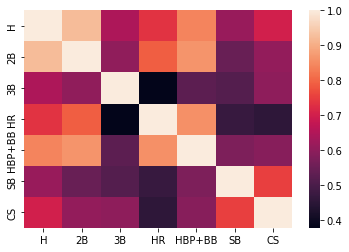

In [4]:
import seaborn as sns

corr = df[['H', '2B', '3B', 'HR', 'HBP+BB', 'SB', 'CS']].corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [5]:
y = df.R
X = sm.add_constant(df.loc[:, ['H', '2B', '3B', 'HR', 'HBP+BB', 'SB', 'CS']])

est = sm.OLS(y, X)

est = est.fit()

In [6]:
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                      R   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     1281.
Date:                Sun, 25 Dec 2022   Prob (F-statistic):          8.81e-145
Time:                        06:40:09   Log-Likelihood:                -838.63
No. Observations:                 180   AIC:                             1693.
Df Residuals:                     172   BIC:                             1719.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5213      7.521     -0.069      0.9